In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Lambda
from keras.models import Model
from keras.losses import mse
import keras.backend as K
from keras.datasets import mnist
import seaborn as sns
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.datasets import mnist

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


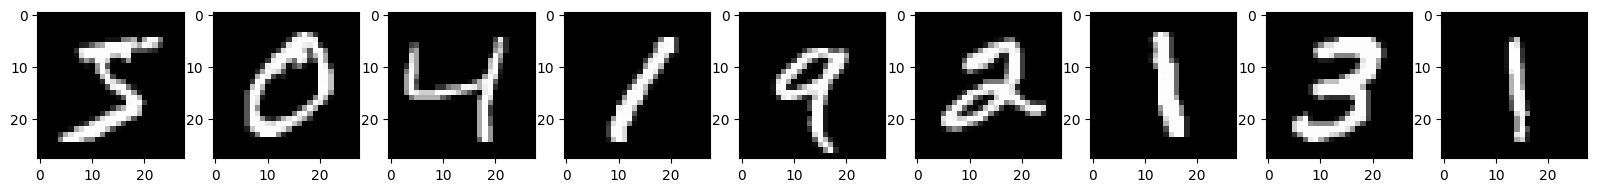

In [3]:
fig = plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(int(191+i))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

### Normalize the data


In [4]:
X_train = X_train / (255./2.) - 1.
X_test = X_test / (255./2.)   - 1.

## Build the Variational Autoencoder (VAE)


In [5]:
NUM_FEATURES = 28
NUM_ONE_SAMPLE = 28
LATENT_DIM = 2
BATCH_SIZE = 128
INTERMEDIATE_DIM = 512

input_shape = (NUM_ONE_SAMPLE, NUM_FEATURES,)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Encoder

In [7]:
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Flatten()(inputs)
x2 = Dense(INTERMEDIATE_DIM, activation='relu')(x1)
z_mean = Dense(LATENT_DIM, name='z_mean')(x2)
z_log_var = Dense(LATENT_DIM, name='z_log_var')(x2)
z = Lambda(sampling, output_shape=(LATENT_DIM,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

## Decoder


In [8]:
latent_inputs = Input(shape=(LATENT_DIM,), name='z_sampling')
x3 = Dense(INTERMEDIATE_DIM, activation='relu')(latent_inputs)
x4 = Dense(NUM_FEATURES * NUM_ONE_SAMPLE, activation='tanh')(x3)
outputs = Reshape((NUM_ONE_SAMPLE, NUM_FEATURES))(x4)
decoder = Model(latent_inputs, outputs, name='decoder')

## Combine the encoder and decoder into the VAE

In [9]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

## Define the loss function

In [10]:
reconstruction_loss = K.sum(mse(inputs, outputs), axis=-1)
reconstruction_loss *= NUM_FEATURES * NUM_ONE_SAMPLE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile the VAE

In [11]:
vae.compile(optimizer='adam')

# Training and Evaluation

In [12]:
epochs = 50
vae.fit(X_train, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test, None))

Epoch 1/50
469/469 [==============================] - 29s 50ms/step - loss: 5004.9058 - val_loss: 4389.9067
Epoch 2/50
469/469 [==============================] - 18s 39ms/step - loss: 4274.1016 - val_loss: 4125.4106
Epoch 3/50
469/469 [==============================] - 14s 30ms/step - loss: 4088.2241 - val_loss: 4023.1538
Epoch 4/50
469/469 [==============================] - 13s 27ms/step - loss: 3993.2974 - val_loss: 3945.6213
Epoch 5/50
469/469 [==============================] - 12s 26ms/step - loss: 3939.1753 - val_loss: 3882.6589
Epoch 6/50
469/469 [==============================] - 12s 25ms/step - loss: 3887.5234 - val_loss: 3848.2651
Epoch 7/50
469/469 [==============================] - 19s 40ms/step - loss: 3843.4243 - val_loss: 3811.4573
Epoch 8/50
469/469 [==============================] - 24s 51ms/step - loss: 3812.4045 - val_loss: 3776.9949
Epoch 9/50
469/469 [==============================] - 12s 26ms/step - loss: 3784.2585 - val_loss: 3758.3330
Epoch 10/50
469/469 [=======

# Analyze the latent space distributions

313/313 [==============================] - 1s 3ms/step


<ipython-input-13-cc3e429137ce>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mean[:, i])
<ipython-input-13-cc3e429137ce>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mean[:, i])


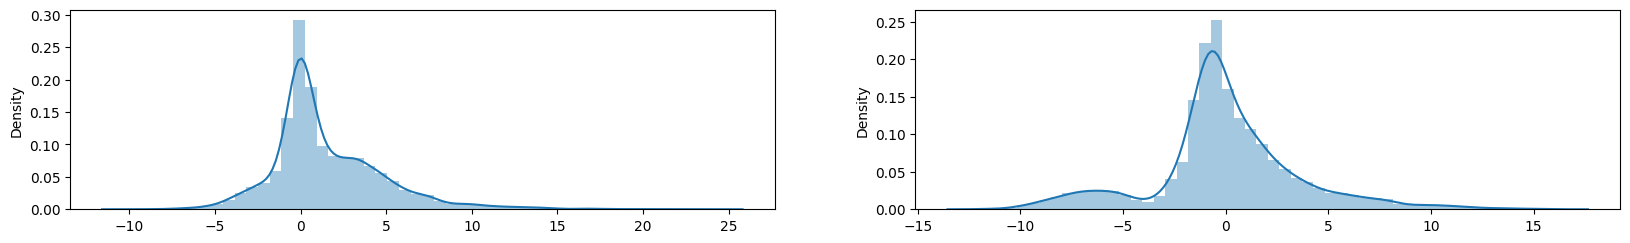

In [13]:
fig = plt.figure(figsize=(20, 15))
dist = encoder.predict(X_test)
mean = dist[0]
var = dist[1]
for i in range(LATENT_DIM):
    plt.subplot(5, 2, i + 1)
    sns.distplot(mean[:, i])
plt.show()

<ipython-input-14-2ae58228871d>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.exp(0.5 * var[:, i]))
<ipython-input-14-2ae58228871d>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.exp(0.5 * var[:, i]))


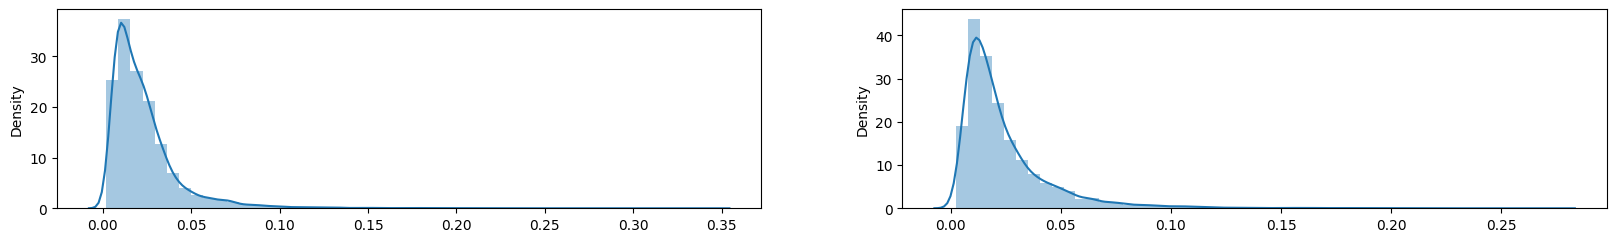

In [14]:
fig = plt.figure(figsize=(20, 15))
for i in range(LATENT_DIM):
    plt.subplot(5, 2, i + 1)
    sns.distplot(np.exp(0.5 * var[:, i]))
plt.show()

# Generate new images from the latent space

32/32 [==============================] - 0s 4ms/step


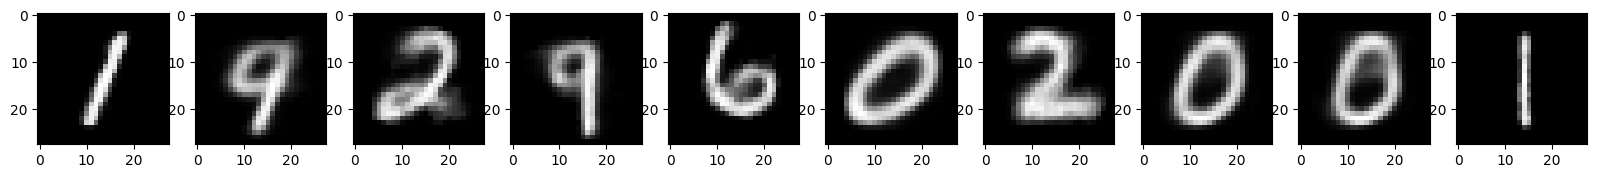

In [15]:
fig = plt.figure(figsize=(20, 15))
num_samples = 1000
idx = np.random.choice(len(mean), num_samples)

lat_ar = np.array([[np.random.normal(m, np.exp(0.5 * v)) for m, v in zip(mean[i], var[i])] for i in idx])
pred = decoder.predict(lat_ar)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(pred[i], cmap=plt.get_cmap('gray'))
plt.show()

## Visualizing the Latent Space
>  Generate a grid of latent points

1/1 [==============================] - 0s 21ms/step


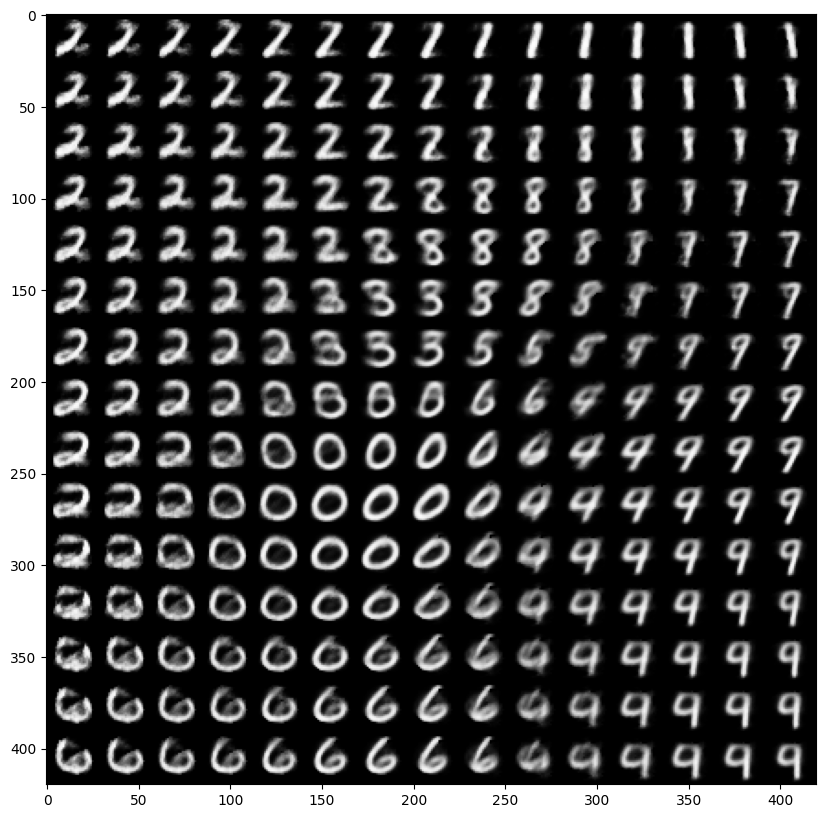

In [16]:
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

# Generate images from the grid of latent points
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) # latent point
        x_decoded = decoder.predict(z_sample) # decode the point
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size:(i + 1) * digit_size,
               j * digit_size:(j + 1) * digit_size] = digit

# Display the generated images
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### Model Visualization

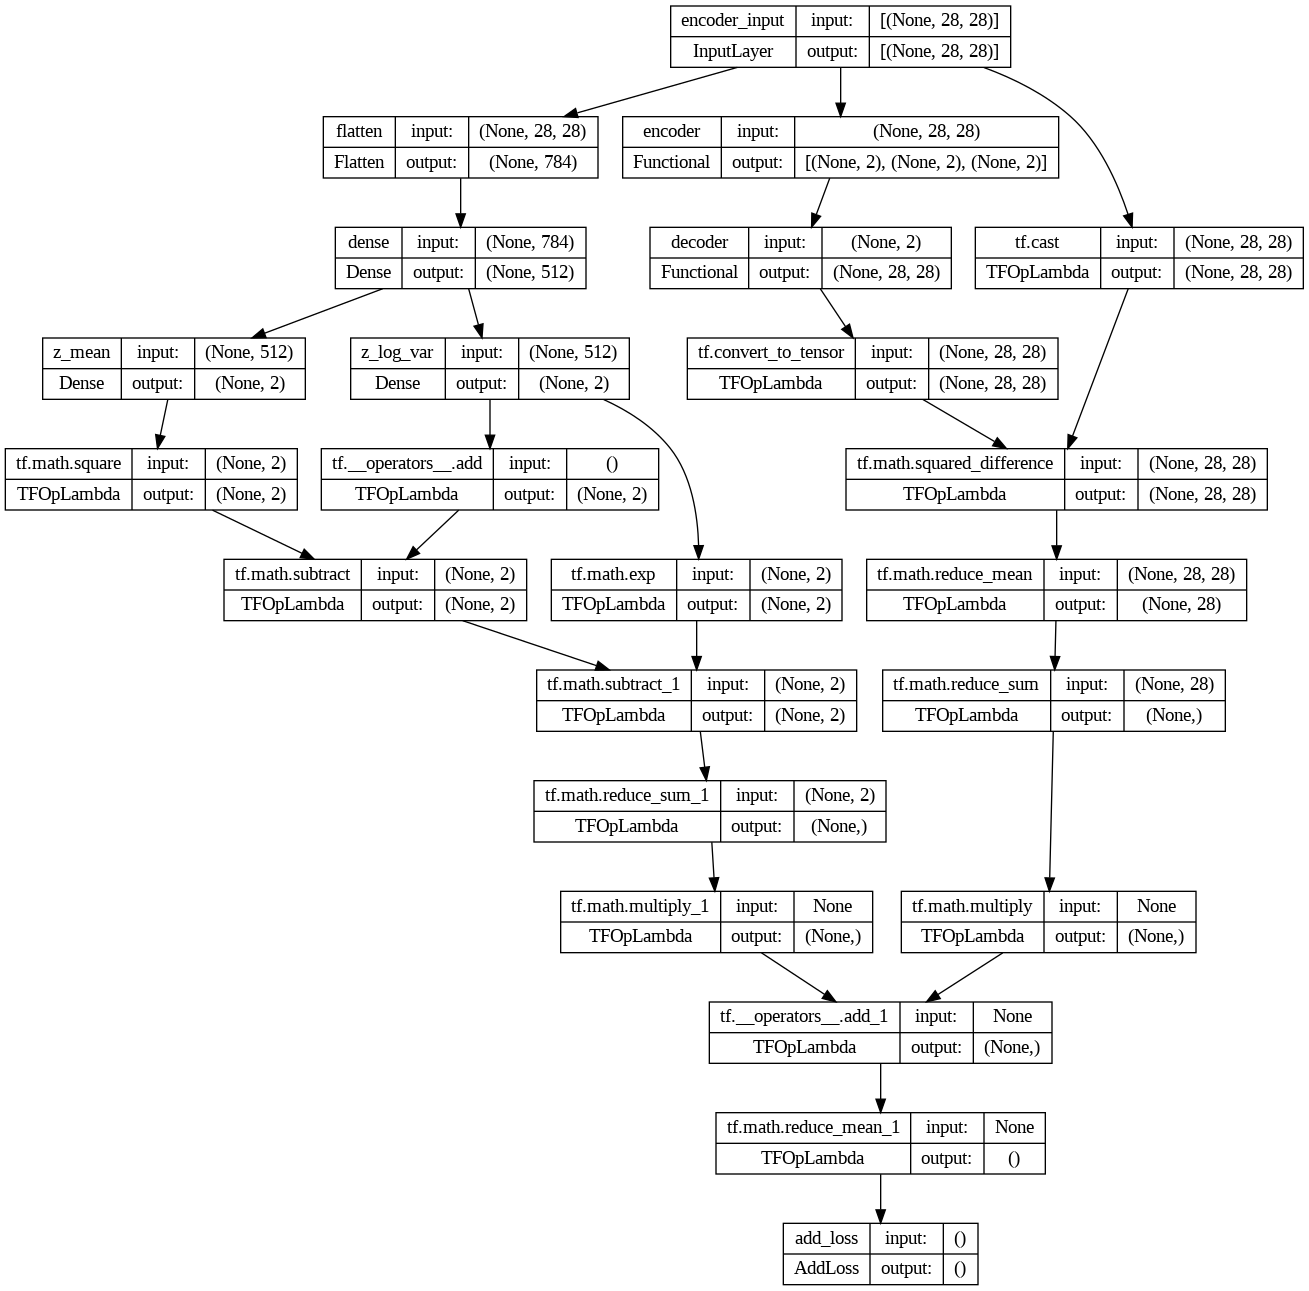

In [17]:
plot_model(vae, to_file='vae_mlp.png', show_shapes=True)